<a href="https://colab.research.google.com/github/spantoskey/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Scott_Pantoskey_DS_Sprint_Challenge_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1*

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [339]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*

 
# Sprint Challenge: Predicting Home Prices in Iowa 🏠

The goal of this assignment is to build a regression model that can predict the sale price of a house in Aimes, Iowa.

# Directions 

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Import training data.
- **Task 2 (`stretch goal`):** Create scatter plot.
- **Task 3:** Split data into feature matrix and target vector.
- **Task 4:** Split data into training and validation sets.
- **Task 5:** Establish baseline mean absolute error.
- **Task 6:** Build and train linear regression model.
- **Task 7:** Build and train ridge regression model.
- **Task 8:** Calculate mean absolute error for training and validation sets.
- **Task 9:** Calculate $R^2$ for validation set.
- **Task 10:** Make predictions based on test set.
- **Task 11 (`stretch goal`):** Get below 18,000 for test set MAE. 
- **Task 12 (`stretch goal`):** Plot model coefficients.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn` 

# Tasks

## I. Wrangle Data

**Task 1:** Since real estate prices fluctuate over time, it's important to index the houses in this dataset using the year in which they were sold. First, load the dataset into a DataFrame named `df` and find the column that states the year sold. Next, modify the code below so that `Yr_Sold` column is parsed as a datetime object and set as the index.

In [340]:
'''T1: Import data into DataFrame `df`.'''
import pandas as pd
import numpy as np

# parse Yr_Sold date and set as index
url_train = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'
df = pd.read_csv(url_train,
                parse_dates = ['Yr_Sold'],
                index_col='Yr_Sold')

# view the head to ensure the changes were implemented correctly
# df.head()

# view data types and null values
# df.info()


**Task 1 Testing**

In [341]:
'''T1 Testing.'''
assert isinstance(df, pd.DataFrame), '`df` is not a DataFrame. Did you import the data?'
assert len(df) == 2564, 'DataFrame `df` has the wrong number of rows.'
assert isinstance(df.index, pd.DatetimeIndex), '`df` does not have a datetime index.'

# **Feature Engineering**

In [342]:
# create new variable if the home was remodeled
df['Remodeled'] = np.where(df['Year_Built'] < df['Year_Remod/Add'], '1', 0)

# create new variable if the home was built before or after year 2000
df['New_or_Old'] = ['New' if x>2000 else 'Newish' if 1980<=x<2000 else 'Old' for x in df['Year_Built']]

# remove high cardinality categoricals
drop_cols = [col for col in df.select_dtypes('object')
              if df[col].nunique() > 10]
df.drop(columns=drop_cols, inplace=True)

# view revised dataframe
df.head()
df.shape


(2564, 45)

**Task 2 (`stretch goal`):** Create a scatter plot that shows `'SalePrice'` as a function of `'Gr_Liv_Area'`. Be sure to label the axes of your plot.

Text(0, 0.5, 'Sale Price [$]')

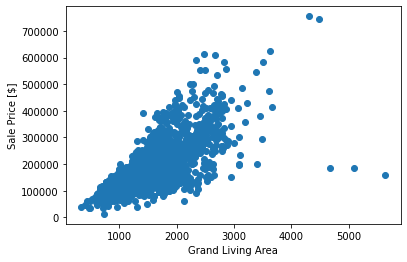

In [343]:
import matplotlib.pyplot as plt

plt.scatter(x='Gr_Liv_Area', y='SalePrice', data=df)
plt.xlabel('Grand Living Area')
plt.ylabel('Sale Price [$]')


## II. Split Data

**Task 3:** Since you're building a model to predict the price at which a house will be sold, your target is the `'SalePrice'` column. Split the DataFrame `df` into the target vector `y` and the feature matrix `X`. 

In [344]:
'''T3: Split `df` into `X` and `y`.'''

# split target vector from feature matrix
target = 'SalePrice'

y= df[target]
X = df.drop(columns=target)

**Task 3 Testing**

In [345]:
'''T3 Tests'''
assert y.shape == (2564,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert X.shape == (2564, 44), '`X` has the wrong number of columns or rows.'
assert 'SalePrice' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Split `X` and `y` into training, validation, and test sets. Since housing prices fluctuate over time, you should use the time-based cutoff method. 

- Training: Homes sold before 2009
- Validation: Homes sold during 2009

In [346]:
'''T4: Split `X` and `y` into training, validation, and testing sets.'''

# Split out the data into train and validate sets
val_cutoff = '2009-01-01'
mask = X.index < val_cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

# verify that the train and validate sets are correct
X_train.sort_index()
# X_val.sort_index()


,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add,Remodeled,New_or_Old
Yr_Sold,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-01,996,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,PConc,2,Typ,2000,1,GasA,Ex,2Story,1,TA,Lvl,Mod,9627,Inside,Reg,60,RL,BrkFace,11,5,7,Y,CompShg,Gable,Normal,WD,Pave,9,AllPub,1993,1994,1,Newish
2006-01-01,1235,1,Twnhs,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,CBlock,1,Typ,1235,0,GasA,Gd,1Story,1,TA,Lvl,Gtl,3760,CulDSac,IR1,120,RL,None,5,5,8,Y,CompShg,Gable,Normal,WD,Pave,4,AllPub,1980,1980,0,Newish
2006-01-01,1208,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,CBlock,1,Typ,1208,1,GasA,TA,1Story,1,TA,Lvl,Gtl,11250,Inside,IR1,20,RL,None,6,6,6,Y,CompShg,Gable,Normal,WD,Pave,6,AllPub,1977,1977,0,Old
2006-01-01,1494,2,TwnhsE,1.0,0.0,Y,Norm,Norm,SBrkr,Gd,Gd,PConc,1,Typ,1494,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,9549,CulDSac,IR1,120,RL,None,4,5,8,Y,CompShg,Hip,Normal,WD,Pave,6,AllPub,1995,1996,1,Newish
2006-01-01,1568,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,PConc,2,Typ,1568,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,7180,Inside,IR1,20,FV,None,9,5,8,Y,CompShg,Gable,Normal,WD,Pave,6,AllPub,2001,2002,1,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-01,1363,2,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,1,Mod,1363,0,GasA,Ex,1Story,1,TA,Low,Sev,39104,CulDSac,IR1,20,RL,None,4,7,7,Y,Membran,Flat,Normal,WD,Pave,5,AllPub,1954,2005,1,Old
2008-01-01,1524,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,2,Typ,1524,0,GasA,TA,1Story,1,TA,Lvl,Gtl,20270,CulDSac,IR1,20,RL,None,4,6,7,Y,CompShg,Gable,Normal,WD,Pave,7,AllPub,1979,1979,0,Old
2008-01-01,1156,4,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,2,Typ,2022,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10005,Inside,Reg,60,RL,BrkFace,3,5,7,Y,CompShg,Hip,Normal,WD,Pave,8,AllPub,1977,1977,0,Old


**Task 4 Testing**

In [347]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 1920, 'Your training set has the wrong number of rows.'
assert len(X_val) == len(y_val) == 644, 'Your validation set has the wrong number of rows.'

## III. Set Baseline

**Task 5:** Before you can create a model to predict sale price, you need to establish a baseline. First, calculate the mean housing price for your training set. Next, calculate the *mean absolute error* for a model that always predicts that mean. Be sure to assign the mean absolute error to a variable named `baseline_mae`.

In [348]:
'''T5: Calculate baseline mean absolute error.'''
from sklearn.metrics import mean_absolute_error

# create a baseline based on the mean housing price; ensure the length of the mean is equal to the length of the target vector
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)

**Task 5 Testing**

In [349]:
'''T5 Tests'''
assert isinstance(baseline_mae, float), '`baseline_mae` is not a `float`. Have you assigned a value to this variable name?'

## IV. Build Models

**Task 6:** Build and train a linear regression model named `model_lr` that predicts home sale price. Your model should have the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `OneHotEncoder`, `use_cat_names` should be set to `True`.

In [350]:
'''T6: Build and train LinearRegression model.'''
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Build a model pipeline with OHE, StandardScaler, LinearRegression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)

model_lr.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 6 Testing**

In [351]:
'''T6 Tests'''
from sklearn.pipeline import Pipeline
assert isinstance(model_lr, Pipeline), '`model_lr` is not a pipeline.'
assert len(model_lr.named_steps) > 1, 'Your `model_lr` pipeline is missing components.'

**Task 7:** Build and train a ridge regression model named `model_r` that predicts home sales price. Your model should include the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** If you combine a `StandardScaler` transformer with a `Ridge` predictor, you should set the `normalize` argument for the latter to `False`.

In [352]:
'''T7. Build and train Ridge model.'''
from sklearn.linear_model import Ridge

model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge(normalize=False)
)
model_r.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Bldg_Type', 'Central_Air', 'Condition_1',
                                     'Condition_2', 'Electrical', 'Exter_Cond',
                                     'Exter_Qual', 'Foundation', 'Functional',
                                     'Heating', 'Heating_QC', 'House_Style',
                                     'Kitchen_Qual', 'Land_Contour',
                                     'Land_Slope', 'Lot_Config', 'Lot_Shape',
                                     'MS_Zoning', 'Mas_Vnr_Type', 'Paved_Drive',
                                     'Roof_Matl', 'Roof_St...
                                     'Utilities', 'Remodeled', 'New_or_Old'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
             

**Task 7 Testing**

In [353]:
assert isinstance(model_r, Pipeline), '`model_r` is not a pipeline.'
assert len(model_r.named_steps) > 1, 'Your `model_r` pipeline is missing components.'

## V. Check Metrics

**Task 8:** Compare your models by calculating their mean absolute error for the training and validation sets. You should assign these to the variables `training_mae` and `validation_mae`, respectively. Your `validation_mae` should be lower than your `baseline_mae`.

In [354]:
'''T8: Compare model metrics, MAE.'''

# check MAE for the model_lr 
y_train_pred_lr = model_lr.predict(X_train)
y_val_pred_lr = model_lr.predict(X_val)

model_lr_training_mae = mean_absolute_error(y_train, y_train_pred_lr)
model_lr_validation_mae = mean_absolute_error(y_val, y_val_pred_lr)

# check MAE for the model_r 
y_train_pred_r = model_r.predict(X_train)
y_val_pred_r = model_r.predict(X_val)

model_r_training_mae = mean_absolute_error(y_train, y_train_pred_r)
model_r_validation_mae = mean_absolute_error(y_val, y_val_pred_r)


print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)

Linear Regression Model
Training MAE: 18043.399165972136
Validation MAE: 29172814951812.125

Ridge Regression Model
Training MAE: 18017.234717788546
Validation MAE: 20085.606324764005


**Task 8 Testing**

In [355]:
'''T8 Tests'''
assert isinstance(model_lr_training_mae, float), '`model_lr_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_lr_validation_mae, float), '`model_lr_validation_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_training_mae, float), '`model_r_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_validation_mae, float), '`model_r_validation_mae` is not a float. Did you assign a value to this variable?'

**Task 9:** Compare your two models by calculating their $R^2$ score for the **validation data**.

In [356]:
'''T9: Compare model metrics, R^2.'''
from sklearn.metrics import r2_score

# check R^2 for the model_lr validation set
y_val_pred_lr = model_lr.predict(X_val)
model_lr_r2_score = r2_score(y_val,y_val_pred_lr)
print(model_lr_r2_score)

# check R^2 for the model_r validation set
y_val_pred_r = model_r.predict(X_val)
model_r_r2_score = r2_score(y_val,y_val_pred_r)
print(model_r_r2_score)


-8.360183533945792e+19
0.8711242541041364


**Task 9 Testing**

In [357]:
'''T9 Tests'''
assert isinstance(model_lr_r2_score, float), '`model_lr_r2_score` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_r2_score, float), '`model_r_r2_score` is not a float. Did you assign a value to this variable?'
assert model_lr_r2_score <= 1, 'The maximum value for an R^2 score is 1.'
assert model_r_r2_score <= 1, 'The maximum value for an R^2 score is 1.'

**Task 10:** Based on the metrics above, choose the best of your two models and generate an array of predictions `y_pred` using the test set below.

**Note:** Make sure that you import and clean the test set *exactly the same way* you did with the training set at the start of this notebook.

In [360]:
url_test = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'

# import the test set, parse the Yr_Sold field and set it as index
X_test = pd.read_csv(url_test,
                     parse_dates = ['Yr_Sold'],
                     index_col='Yr_Sold')

# create new variable if the home was remodeled
X_test['Remodeled'] = np.where(X_test['Year_Built'] < X_test['Year_Remod/Add'], '1', 0)

# create new variable if the home was built before or after year 2000
X_test['New_or_Old'] = ['New' if x>2000 else 'Newish' if 1980<=x<2000 else 'Old' for x in X_test['Year_Built']]

# remove high cardinality categoricals
drop_cols = [col for col in X_test.select_dtypes('object')
              if X_test[col].nunique() > 10]
X_test.drop(columns=drop_cols, inplace=True)

# view head of the test set
X_test.head()


# predict y_pred based on the ridge regression model since it had a lower MAE and we are using categorical variables
y_pred = model_r.predict(X_test)
y_pred




array([209001.04762865,  98165.89308438, 165742.18228001, 302287.75010879,
       167804.36701376, 182729.06195869, 211992.16939146, 207006.72162248,
       235442.16942682, 200049.8082896 , 176507.64717501, 188646.23926364,
       160954.14628997, 202493.07275462, 219648.12735642, 487747.50299937,
       221623.49104518, 329030.95985858,  98093.46469536, 237152.9158808 ,
       215902.36947487, 175650.08011183, 220016.45789857, 176890.24657103,
       156751.10248751, 140383.09092037, 110584.38619856,  76943.83647191,
       189196.60464072,  82340.05456707,  77802.22194791,  85441.26004349,
       124148.43538628, 123947.91129837, 117755.26718451, 122233.19991257,
       366634.20040281, 260578.88415451, 379787.01377311, 241688.13089261,
       227338.75193041, 322019.56646663, 303194.28144012, 217131.61953307,
       412009.81641277, 215955.54900276, 460603.95021258, 285507.4086784 ,
       344707.17799247, 203987.02438231, 186486.83149161, 189406.92040373,
       171895.41442858, 1

**Task 10 Testing:** There is a hidden test in the cell below. When you submit your notebook to Canvas, your test MAE will be calculated. In order to get the point for this task, your test MAE must be below 58,000.

**Tip:** Use your validation MAE to estimate what your test MAE will be.

In [362]:
import numpy as np
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

**Task 11 (`stretch goal`):** There's no code to write for this task. Below is another testing cell that will calculate the MAE for your test set. In order to get the point for this task, your test MAE must be below 18,000.

**Tip:** Are there any **hyperparameters** in your model that you could adjust to improve performance? 

In [363]:
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

## VI. Explain Model

**Task 12 (`stretch goal`):** Create a horizontal barchart for your best performing model that shows the ten most important features for the model's predictions. Don't forget to label your axes!

Text(0.5, 1.0, 'Top 10 Features for Predicting Housing Prices in Terms of Importance')

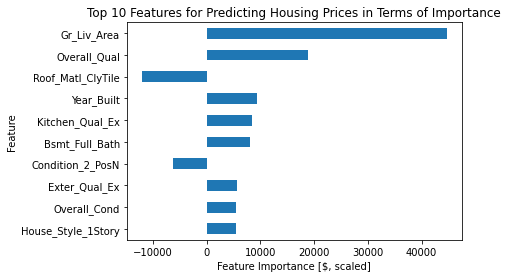

In [374]:
# step 1: get the coefficients
coefficients = model_r.named_steps['ridge'].coef_
coefficients

# step 2: get the feature names from ONE
feat_names = model_r.named_steps['onehotencoder'].get_feature_names()

# join the coefficients and feature names in a Series and plot it
pd.Series(coefficients, index=feat_names).sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel('Feature Importance [$, scaled]')
plt.ylabel('Feature')
plt.title('Top 10 Features for Predicting Housing Prices in Terms of Importance')